In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
import sys
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *
from Models.SimpleRNN_NC import SimpleRNN_NC

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

## Load data

In [3]:
data_path = './Data/Processed_Data/Tidy_Sansa_13_04.pkl'

with open(data_path, 'rb') as file:
    df = pickle.load(file)

In [4]:
baseline_df = df.loc[df.type == 'BASELINE'].reset_index()

In [5]:
stim_df = df.loc[df.type == 'TONIC'].reset_index()

In [6]:
X_train_b, y_train_b, X_val_b, y_val_b, X_test_b, y_test_b, info_train_b, info_val_b, info_test_b = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)
X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s, info_train_s, info_val_s, info_test_s = train_test_split(stim_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)
# Test one of the folds first
fold_num = 'fold1'
fold = 1



print('We are testing the optimization method on fold ', fold)

def input_mats(x,y, seq_length = 75):
    x = x[fold_num]
    y = y[fold_num]
    x = x.reshape(x.shape[0] // seq_length, seq_length, x.shape[1])  
    y = y.reshape(y.shape[0] // seq_length, seq_length, y.shape[1])  
    return x,y

x_train_base, y_train_base = input_mats(X_train_b, y_train_b)
x_train_stim, y_train_stim = input_mats(X_train_s, y_train_s)

x_val_base, y_val_base = input_mats(X_val_b, y_val_b)
x_val_stim, y_val_stim = input_mats(X_val_s, y_val_s)

x_test_base, y_test_base = input_mats(X_test_b, y_test_b)
x_test_stim, y_test_stim = input_mats(X_test_s, y_test_s)

seed = 42
torch.manual_seed(seed)

Test trials  4
Val trials 3
Test trials  8
Val trials 7
We are testing the optimization method on fold  1


## Model

In [7]:
def create_state_dict(param_names, param_values):
    s_d = {}
    for n,v in zip(param_names, param_values):
        s_d[n] = v
    return s_d

In [8]:
import torch
import torch.nn as nn

class dev_model(nn.Module):
    def __init__(self,  hnet_output, 
                    num_features=124, 
                    hidden_size= 3, #was 128
                    #initial_offset = -2,
                    num_layers = 2, 
                    input_size = 50,
                    out_dims = 6, 
                    dropout_1 = 0.3, 
                    dropout_2 = 0.3, 
                    bias = True,
                    LSTM_ = False):
        
        super(dev_model, self).__init__()
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hnet_output = hnet_output
        self.bias = bias
        self.out_features = out_dims
        self.LSTM_ = LSTM_

        self.dropout1 = nn.Dropout(p= dropout_1) #trial.suggest_float('dropout_1', 0.1, 0.9)
        self.dropout2 = nn.Dropout(p= dropout_2)

        # Define recurrent layer
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, self.bias, batch_first = True, bidirectional = False)
        names_p = [name for name, _ in self.rnn.named_parameters()]
        self.hnet_output_dict = create_state_dict(names_p,hnet_output[4:] )

        # Initialize CustomRNN
        if self.LSTM_:
            self.rnn = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, self.bias, batch_first = True, bidirectional = False)
            names_p = [name for name, _ in self.rnn.named_parameters()]
            self.hnet_output_dict = create_state_dict(names_p,hnet_output[4:] )            

    def forward(self, x, hx=None):
        x = F.linear(x, self.hnet_output[0], bias=self.hnet_output[1])
        x = self.dropout1(x)
        # Forward pass
        if hx is None:
            if self.LSTM_:
                h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=x.device) * 0.1
                c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=x.device) *0.1 # Initialize cell state
                hx = (h0, c0)
            else:
                hx = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=x.device) * 0.1
        
        # Perform RNN operation
        x, _  = torch.func.functional_call(self.rnn, self.hnet_output_dict, (x, hx))
        #self.lstm.flatten_parameters()  # Add this line to flatten parameters
        #x, _ = self.lstm(x) 
        x = self.dropout2(x)
        output =  F.linear(x, self.hnet_output[2], bias=self.hnet_output[3])
        # Apply sigmoid activation function
        output = torch.sigmoid(output)
        
        return output.squeeze() 


#### Define a template model only to get automatically the model parameters shapes

In [9]:
class template_LSTM(nn.Module):
    def __init__(self, num_features=124, 
                    hidden_units= 3, #was 128
                    #initial_offset = -2,
                    num_layers = 2, 
                    input_size = 50,
                    out_dims = 6, 
                    dropout_1 = 0.3, 
                    dropout_2 = 0.3):
        super(template_LSTM, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.input_size = input_size
            
        self.linear1 = nn.Linear(in_features=self.num_features, out_features= self.input_size)
        self.linear2 = nn.Linear(in_features=self.hidden_units, out_features=out_dims)

        self.lstm = nn.LSTM(
            input_size= self.input_size,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers= num_layers,
            bidirectional=False,)
        
        self.dropout1 = nn.Dropout(p= dropout_1) #trial.suggest_float('dropout_1', 0.1, 0.9)
        self.dropout2 = nn.Dropout(p= dropout_2) 

    def forward(self, x):

        x = self.linear1(x)
        x = self.dropout1(x)
        x, _ = self.lstm(x)
        x = self.dropout2(x)
        output = self.linear2(x)
        # Apply sigmoid activation function
        output = torch.sigmoid(output)
        
        return output.squeeze()
    

From the LSTM trained on stim data only (no hypernet):

- n_hidden_units = 32

- num_layers = 5

- input_size_LSTM = 31

- dropout_1 = 0.45353387311567006

- dropout_2 = 0.43469775095920277

- lr = 0.0017186636685695396

- lr_gamma = 1.4869841187864843

- seq_length_LSTM = 17

- batch_size_train = 33

- batch_size_val = 34

- huber_delta = 7

- alpha_reg = 6.5952774295107e-06

- l1_ratio_reg = 0.38894691744111975

In [10]:
num_dim_output = y_train_base.shape[2]
num_features = x_train_base.shape[2]

# Hyperparameters LSTM class (from stim model without hnet)
n_hidden_units = 32
num_layers = 1 #5
input_size_LSTM = 31
dropout_1 = 0.85 #0.45
dropout_2 = 0.65 #0.43


In [11]:
template_m = template_LSTM(num_features=num_features, 
                    hidden_units= n_hidden_units, 
                    num_layers = num_layers, 
                    input_size = input_size_LSTM,
                    out_dims = num_dim_output, )

In [12]:
param_shapes = [p.shape for p in list(template_m.parameters())]

In [13]:
from hypnettorch.hnets import HMLP

num_conditions = 2
size_task_embedding = 8

hnet = HMLP(param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[13], 
            num_cond_embs=num_conditions).to(device)

Created MLP Hypernet.
Hypernetwork with 173551 weights and 12387 outputs (compression ratio: 14.01).
The network consists of 173535 unconditional weights (173535 internally maintained) and 16 conditional weights (16 internally maintained).


In [14]:
for param in hnet.parameters():
    param.requires_grad = True

In [15]:
w_test = hnet(cond_id = 0)

In [16]:
LSTM_ = True

In [17]:
model = dev_model(num_features= num_features, hnet_output = w_test,  hidden_size = n_hidden_units,
                            num_layers= num_layers, input_size = input_size_LSTM,out_dims=num_dim_output,  
                            dropout_1= dropout_1, dropout_2= dropout_2, LSTM_ = LSTM_).to(device)

In [18]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
def reg_test(weights, alpha, l1_ratio):
    
    """
    Implement an L1-L2 penalty on the norm of the model weights.

    model: MLP
    alpha: scaling parameter for the regularization.
    l1_ratio: mixing parameter between L1 and L2 loss.

    Returns:
    reg: regularization term
    """
    l1_loss = 0
    l2_loss = 0

    # Accumulate L1 and L2 losses for weight matrices in the model
    

    weights_ =  [i for i in weights if len(i.shape)==2]

    for weight_tensor in weights_[2]:
        l1_loss += torch.sum(torch.abs(weight_tensor))
        l2_loss += torch.sum(weight_tensor.pow(2))

    reg = l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss

    reg = alpha * reg

    # Accumulate L1 and L2 losses for weight matrices in the model
    for weight_tensor in weights_:
        l1_loss += torch.sum(torch.abs(weight_tensor))
        l2_loss += torch.sum(weight_tensor.pow(2))

    reg_item = l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss

    reg_item = alpha * reg_item

    total_reg = reg + reg_item.item()

    return reg_item.item()


In [20]:
def init_hnet(model):
    # Initialize weights
    for i, layer in enumerate(model.layer_weight_tensors[:-1]):
        nn.init.kaiming_uniform_(layer, mode='fan_in', nonlinearity='relu')
        if model.has_bias:
            nn.init.zeros_(model.layer_bias_vectors[i])
        

In [21]:
def train_hypernet(model, hnet,y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=0.0001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM=15,
                batch_size_train = 25,
                batch_size_val = 25,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=None,
                l1_ratio = 0.5,
                alpha_A = 1e-5,  
                alpha_B = 1e-5,        
                early_stop = 10,
                LSTM_ = LSTM_,
                chunks = False
                
                ):

    
    # Initialize the hypernetwork

    # --> this was only when using th models from hypnettorch
    """     if chunks:
         hnet.apply_chunked_hyperfan_init(mnet = model)
    else: 
         hnet.apply_hyperfan_init(mnet=model) """
    
    # Initialize the weights and biases of the hnet
    #init_hnet(hnet) #--> need to check what works better
    # Set up the optimizer with the specified learning rate
    optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset_baseline = SequenceDataset(
    y_train_base,    x_train_base,    sequence_length=sequence_length_LSTM)

    train_dataset_stim = SequenceDataset(
    y_train_stim,    x_train_stim,    sequence_length=sequence_length_LSTM)

    val_dataset_baseline = SequenceDataset(
    y_val_base,    x_val_base,    sequence_length=sequence_length_LSTM)

    val_dataset_stim = SequenceDataset(
    y_val_stim,    x_val_stim,    sequence_length=sequence_length_LSTM)

    loader_train_b = data.DataLoader(train_dataset_baseline, batch_size=batch_size_train, shuffle=True)
    loader_train_s = data.DataLoader(train_dataset_stim, batch_size=batch_size_train, shuffle=True)

    loader_val_b = data.DataLoader(val_dataset_baseline, batch_size=batch_size_val, shuffle=True)
    loader_val_s = data.DataLoader(val_dataset_stim, batch_size=batch_size_val, shuffle=True)

    # Initialize h0 and c0 outside the model
    if LSTM_ == True:

        h0 = torch.randn(num_layers, batch_size_train, n_hidden_units, device=device) * 0.1
        c0 = torch.randn(num_layers, batch_size_train, n_hidden_units, device=device) *0.1 # Initialize cell state
        hx = (h0, c0) 
    else:
        hx = torch.randn(num_layers, batch_size_train, n_hidden_units, device=device) * 0.1
    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loaders = zip(loader_train_b, loader_train_s)
            else:
                model.eval()
                loaders = zip(loader_val_b, loader_val_s)

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for data_b, data_s in loaders:

                # Define data for this batch
                x_b = data_b[0].to('cuda')
                y_b = data_b[1].to('cuda')
                x_s = data_s[0].to('cuda')
                y_s = data_s[1].to('cuda')
               
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        # Compute BASELINE loss.
                        W_base = hnet(cond_id=0)
                        model = dev_model(num_features= num_features, hnet_output = W_base,  hidden_size = n_hidden_units,
                            num_layers= num_layers, input_size = input_size_LSTM,out_dims=num_dim_output,  
                            dropout_1= dropout_1, dropout_2= dropout_2, LSTM_ = LSTM_).to(device)
                                    
                        base_P = model(x_b, hx)
                        
                        loss_base = huber_loss(base_P, y_b, delta = delta)
                        
                        
                        # Compute STIMULATION loss.
                        W_stim = hnet(cond_id=1)
                        model = dev_model(num_features= num_features, hnet_output = W_stim,  hidden_size = n_hidden_units,
                            num_layers= num_layers, input_size = input_size_LSTM,out_dims=num_dim_output,  
                            dropout_1= dropout_1, dropout_2= dropout_2, LSTM_ = LSTM_).to(device)          
                        stim_P = model(x_s, hx)
                        loss_stim = huber_loss(stim_P, y_s, delta = delta)
                        
                        # Combine loss for 2 tasks
                        loss_t = loss_base + loss_stim    #only for printing

                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            loss_stim_reg = loss_stim + reg_test(W_stim, l1_ratio, alpha_B)
                            loss_base_reg = loss_base + reg_test(W_base, l1_ratio, alpha_A)
                            # Combine loss for 2 tasks
                            loss_t_r = loss_base_reg + loss_stim_reg

                        else:               
                            loss_t_r = loss_t 
                        
                        

                        # Compute gradients and perform an optimization step
                        loss_t_r.backward()
                        optimizer.step()


                else:
                    # just compute the loss in validation phase
                    W_base = hnet(cond_id=0)
                    model = dev_model(num_features= num_features, hnet_output = W_base,  hidden_size = n_hidden_units,
                            num_layers= num_layers, input_size = input_size_LSTM,out_dims=num_dim_output,  
                            dropout_1= dropout_1, dropout_2= dropout_2, LSTM_ = LSTM_).to(device)          
                    base_P = model(x_b, hx)
                    loss_base = huber_loss(base_P, y_b, delta = delta)

                    W_stim = hnet(cond_id=1)
                    model = dev_model(num_features= num_features, hnet_output = W_stim,  hidden_size = n_hidden_units,
                            num_layers= num_layers, input_size = input_size_LSTM,out_dims=num_dim_output,  
                            dropout_1= dropout_1, dropout_2= dropout_2, LSTM_ = LSTM_).to(device)          
                    stim_P = model(x_s, hx)
                    loss_stim = huber_loss(stim_P, y_s, delta = delta)

                    loss_t = loss_base + loss_stim

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                assert torch.isfinite(loss_t_r)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_wbase= W_base
                    best_wstim = W_stim
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses), best_wbase, best_wstim

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses), best_wbase, best_wstim

In [22]:
lr = 0.0001 # 0.0017
lr_gamma = 1.49
seq_length_LSTM = 15
batch_size_train = 25
batch_size_val = 25
huber_delta = 7
alpha_reg = 1e-1
l1_ratio_reg = 0.39

In [23]:
t_losses, val_losses, W_base, W_stim = train_hypernet(model, hnet,y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=lr,
                lr_step_size=5,
                lr_gamma= lr_gamma, #0.9
                sequence_length_LSTM = seq_length_LSTM, #15
                batch_size_train = batch_size_train, #15
                batch_size_val = batch_size_train, #15
                num_epochs=1000, 
                delta = huber_delta,   #8             
                regularizer=reg_hnet_noweights,
                l1_ratio = l1_ratio_reg, #0.5
                alpha_A = alpha_reg, 
                alpha_B = alpha_reg,     
                early_stop = 5,
                chunks = False)

Epoch 000 Train 0.0923 Val 0.1299
Epoch 001 Train 0.0871 Val 0.1207
Epoch 002 Train 0.0827 Val 0.1170
Epoch 003 Train 0.0789 Val 0.1128
Epoch 004 Train 0.0752 Val 0.1090
Epoch 005 Train 0.0715 Val 0.1039
Epoch 006 Train 0.0679 Val 0.1003
Epoch 007 Train 0.0637 Val 0.0961
Epoch 008 Train 0.0605 Val 0.0936
Epoch 009 Train 0.0587 Val 0.0898
Epoch 010 Train 0.0549 Val 0.0867
Epoch 011 Train 0.0515 Val 0.0826
Epoch 012 Train 0.0482 Val 0.0773
Epoch 013 Train 0.0451 Val 0.0724
Epoch 014 Train 0.0428 Val 0.0705
Epoch 015 Train 0.0400 Val 0.0678
Epoch 016 Train 0.0369 Val 0.0631
Epoch 017 Train 0.0344 Val 0.0619
Epoch 018 Train 0.0328 Val 0.0588
Epoch 019 Train 0.0312 Val 0.0579
Epoch 020 Train 0.0296 Val 0.0575
Epoch 021 Train 0.0287 Val 0.0538
Epoch 022 Train 0.0270 Val 0.0549
Epoch 023 Train 0.0264 Val 0.0511
Epoch 024 Train 0.0257 Val 0.0530
Epoch 025 Train 0.0250 Val 0.0514
Epoch 026 Train 0.0242 Val 0.0514
Epoch 027 Train 0.0234 Val 0.0496
Epoch 028 Train 0.0229 Val 0.0510
Epoch 029 Trai

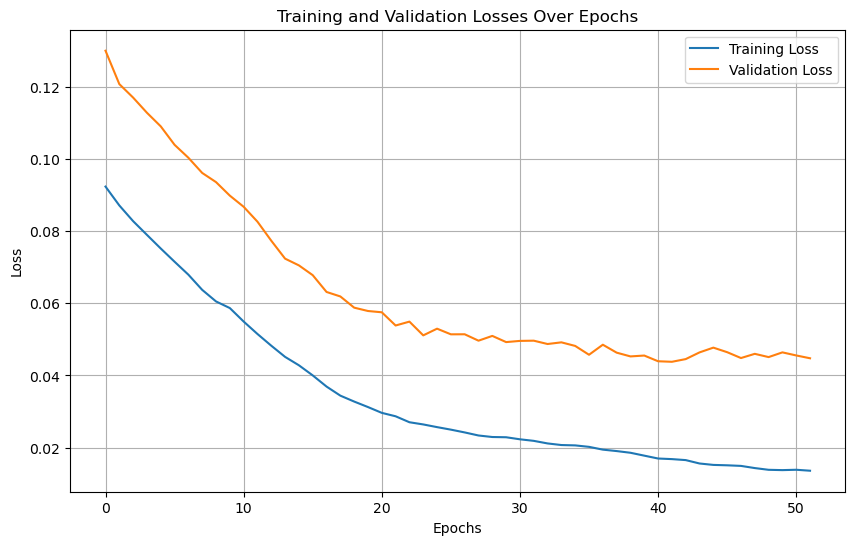

In [24]:
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(t_losses, val_losses)

In [25]:
def calc_explained_variance(x, y, weights):
    """Compute the explained variance for a given dataset"""
    with torch.no_grad():
        # Process complete dataset as one batch.
        # Convert X_train and y_train to PyTorch tensors
        inputs = torch.tensor(x, device=device, dtype=torch.float32)
        targets = torch.tensor(y, device=device, dtype=torch.float32)

        model = dev_model(num_features= num_features, hnet_output = weights,  hidden_size = n_hidden_units,
                            num_layers= num_layers, input_size = input_size_LSTM,out_dims=num_dim_output,  
                            dropout_1= 0.2, dropout_2= 0.2, LSTM_ = LSTM_).to(device)

        # Forward pass to get predictions
        predictions = model(inputs)

        y_array = targets.detach().cpu().numpy()
        y_pred_array = predictions.detach().cpu().numpy()
     
        # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
        y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
        y_true_2D = y_array.reshape(-1, y_array.shape[-1])

        # Compute explained variance
        r2 = explained_variance_score(y_true_2D, y_pred_2D)

    return r2

In [26]:
subsets = ['Training', 'Validation', 'Test']

data_base = [[x_train_base, y_train_base],
             [x_val_base, y_val_base],
             [x_test_base, y_test_base]]

data_stim = [[x_train_stim, y_train_stim],
             [x_val_stim, y_val_stim],
             [x_test_stim, y_test_stim]]

In [27]:
for index, [x,y] in enumerate(data_base):
    r2 = calc_explained_variance(x, y, W_base)
    print('Explained variance score for ', subsets[index], ' is : ', r2)


Explained variance score for  Training  is :  0.7107868393262228
Explained variance score for  Validation  is :  0.6258383194605509
Explained variance score for  Test  is :  0.6260943015416464


In [28]:
for index, [x,y] in enumerate(data_stim):
    r2 = calc_explained_variance(x, y, W_stim)
    print('Explained variance score for ', subsets[index], ' is : ', r2)

Explained variance score for  Training  is :  0.6860316197077433
Explained variance score for  Validation  is :  0.5687311291694641
Explained variance score for  Test  is :  0.5566311279932658
